# Rag From Scratch: Indexing

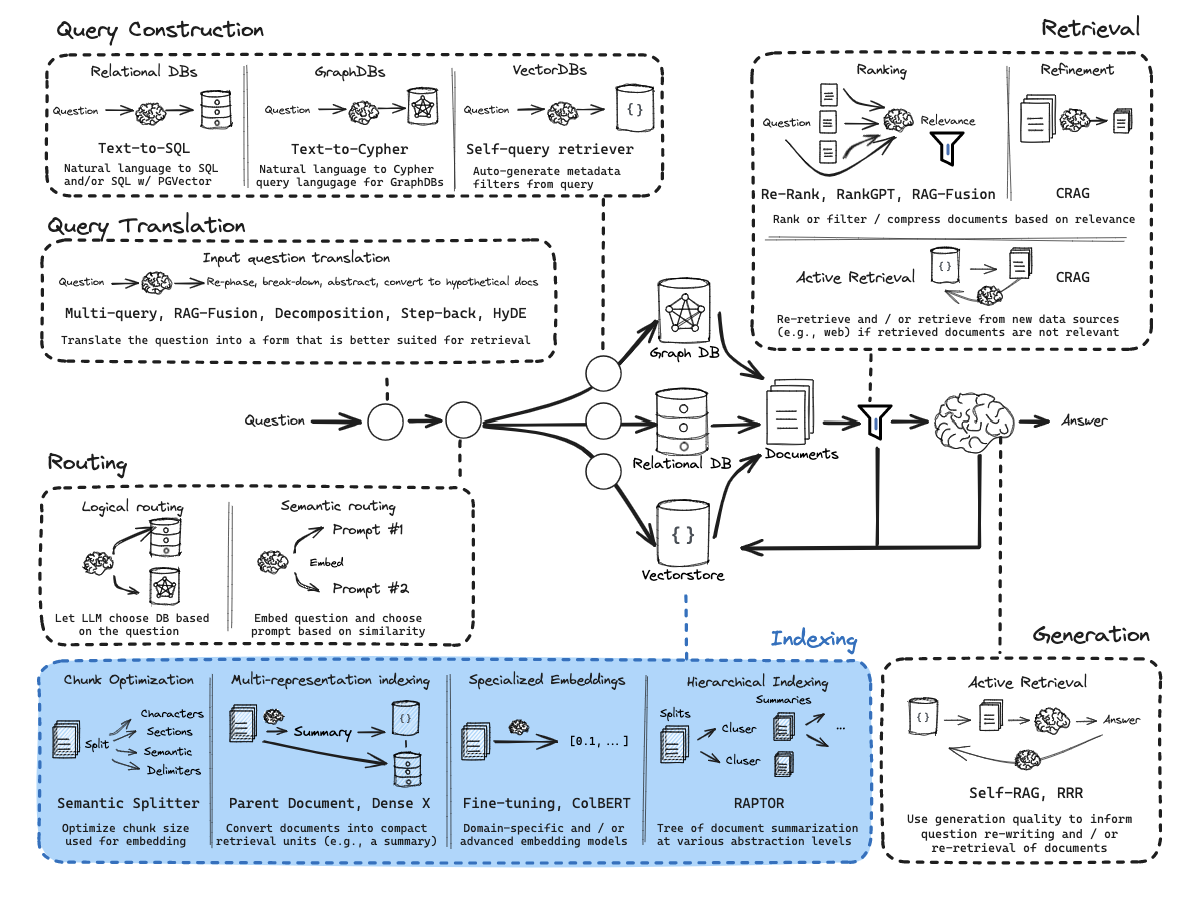

## Preface: Chunking

We don't explicity cover document chunking / splitting.

## Environment

(1) Packages

In [1]:
# ! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain youtube-transcript-api pytube

(2) LangSmith

In [2]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
from dotenv import load_dotenv

LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
HUGGINGFACEHUB_API_TOKEN = os.getenv("HUGGINGFACEHUB_API_TOKEN")

(3) API Keys

In [3]:
# os.environ['OPENAI_API_KEY'] = <your-api-key>

## Part 12: Multi-representation Indexing

Flow:



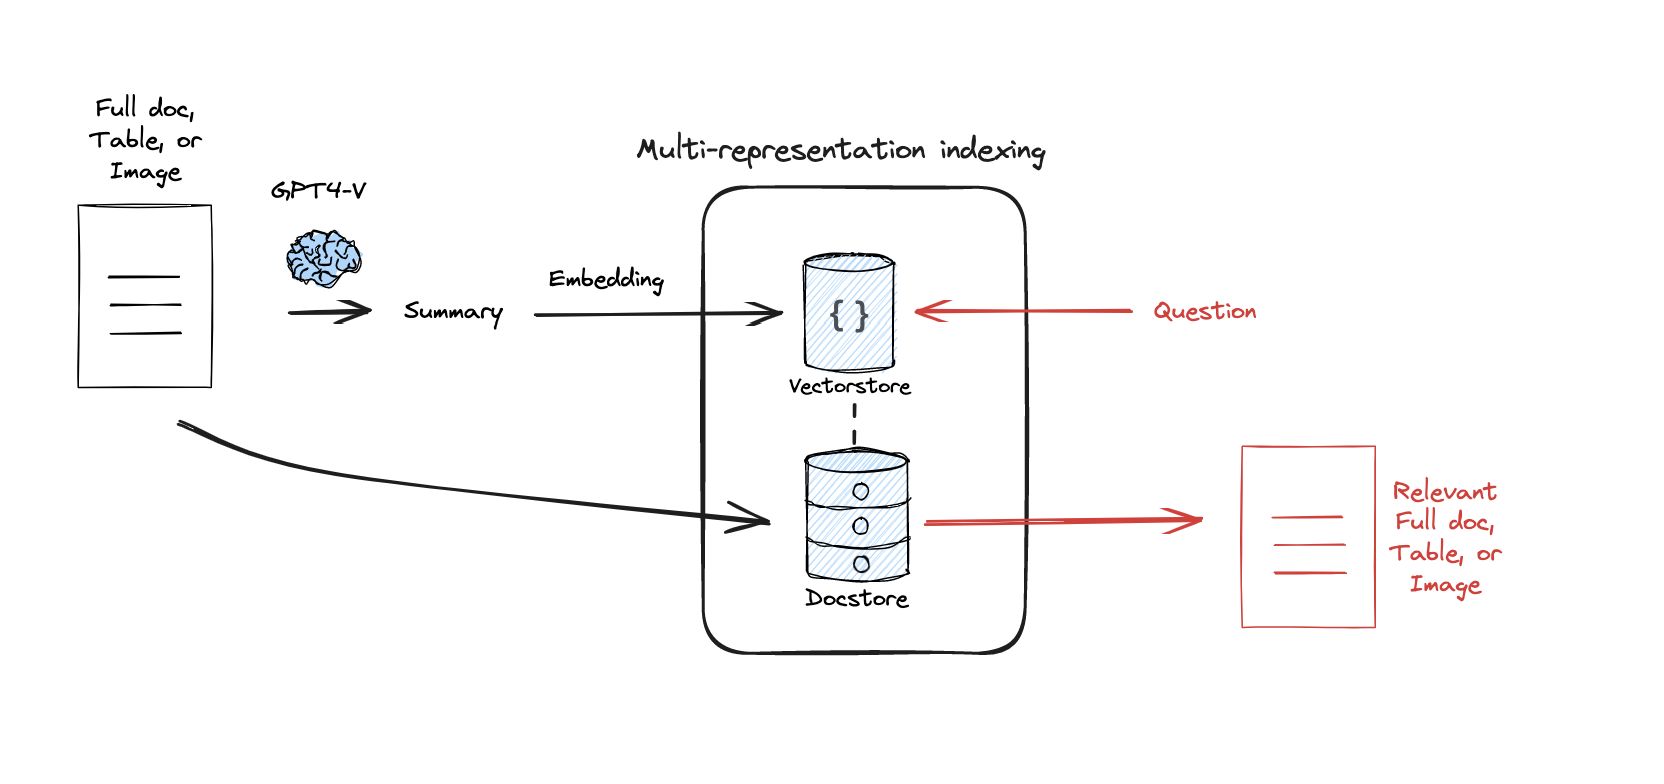

In [4]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

loader = WebBaseLoader("https://lilianweng.github.io/posts/2024-02-05-human-data-quality/")
docs.extend(loader.load())

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
import uuid

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.llms import Ollama
chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | Ollama(model = 'llama3.2')
    | StrOutputParser()
)

summaries = chain.batch(docs, {"max_concurrency": 5})

/var/folders/42/94lj0cp519ncj7_m79j3_h3m0000gn/T/ipykernel_5326/1724340915.py:11: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  | Ollama(model = 'llama3.2')
/opt/anaconda3/envs/ollama-rag/lib/python3.11/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
Failed to multipart ingest runs: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=c516d918-decf-4865-ad13-13098e4bd42d,id=c516d918-decf-4865-ad13-13098e4bd42d

Failed to multipart ingest runs: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=c516d918-decf-4865-ad13-13098e4bd42d,id=b15e2f0e-16cf-4db5-8c78-5753c5c6dc9d; trace=5c3447b5-4577-4024-adfe-c48918e96dc0,id=e85b18ee-df29-44de-972b-a9ad755b008d; trace=c516d918-decf-4865-ad13-13098e4bd42d,id=a1b5651d-d7ac-479b-b3e3-ecc9fee415b5; trace=5c3447b5-4577-4024-adfe-c48918e96dc0,id=f72fe8ad-5c35-4e13-b2e0-c1c633e6cb4c; trace=c516d918-decf-4865-ad13-13098e4bd42d,id=c516d918-decf-4865-ad13-13098e4bd42d; trace=5c3447b5-4577-4024-adfe-c48918e96dc0,id=5c3447b5-4577-4024-adfe-c48918e96dc0
Failed to multipart ingest runs: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com

In [6]:
from langchain.storage import InMemoryByteStore
from langchain_openai import OpenAIEmbeddings
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries",
                     embedding_function=HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2"))

# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

# Docs linked to summaries
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

# Add
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

/var/folders/42/94lj0cp519ncj7_m79j3_h3m0000gn/T/ipykernel_5326/1667387974.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function=HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2"))
/opt/anaconda3/envs/ollama-rag/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/42/94lj0cp519ncj7_m79j3_h3m0000gn/T/ipykernel_5326/1667387974.py:8: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be

In [7]:
query = "Memory in agents"
sub_docs = vectorstore.similarity_search(query,k=1)
sub_docs[0]

Document(metadata={'doc_id': '18200f06-fd23-48bf-85ba-c9f38303acac'}, page_content='Based on the provided text, I will generate a summary of the main points in a neutral tone.\n\n**LLM-Powered Autonomous Agents**\n\nRecent advancements in large language models (LLMs) have enabled the development of autonomous agents that can perform complex tasks. These agents rely on LLMs as their primary interface with external components such as memory and tools. However, there are several challenges associated with these systems, including:\n\n* **Reliability of natural language interface**: The reliability of model outputs is questionable, and LLMs may make formatting errors or exhibit rebellious behavior.\n* **Citation limitations**: There is a lack of rigorous evaluation and benchmarking of LLM-powered autonomous agents.\n\nTo address these challenges, researchers have proposed various solutions, including:\n\n* **Chain of thought prompting**: A method that elicits reasoning in LLMs.\n* **Tree o

In [8]:
retrieved_docs = retriever.get_relevant_documents(query,n_results=1)
retrieved_docs[0].page_content[0:500]

/var/folders/42/94lj0cp519ncj7_m79j3_h3m0000gn/T/ipykernel_5326/3791815623.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(query,n_results=1)
Number of requested results 4 is greater than number of elements in index 2, updating n_results = 2


"\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS"

## Part 13: RAPTOR: Recursive Abstractive Processing for Tree-Organized Retrieval

The RAPTOR paper presents an interesting approaching for indexing and retrieval of documents:

- The leafs are a set of starting documents
- Leafs are embedded and clustered
- Clusters are then summarized into higher level (more abstract) consolidations of information across similar documents

This process is done recursivly, resulting in a "tree" going from raw docs (leafs) to more abstract summaries.

We can applying this at varying scales; leafs can be:

- Text chunks from a single doc (as shown in the paper)
- Full docs (as we show below)
With longer context LLMs, it's possible to perform this over full documentslow


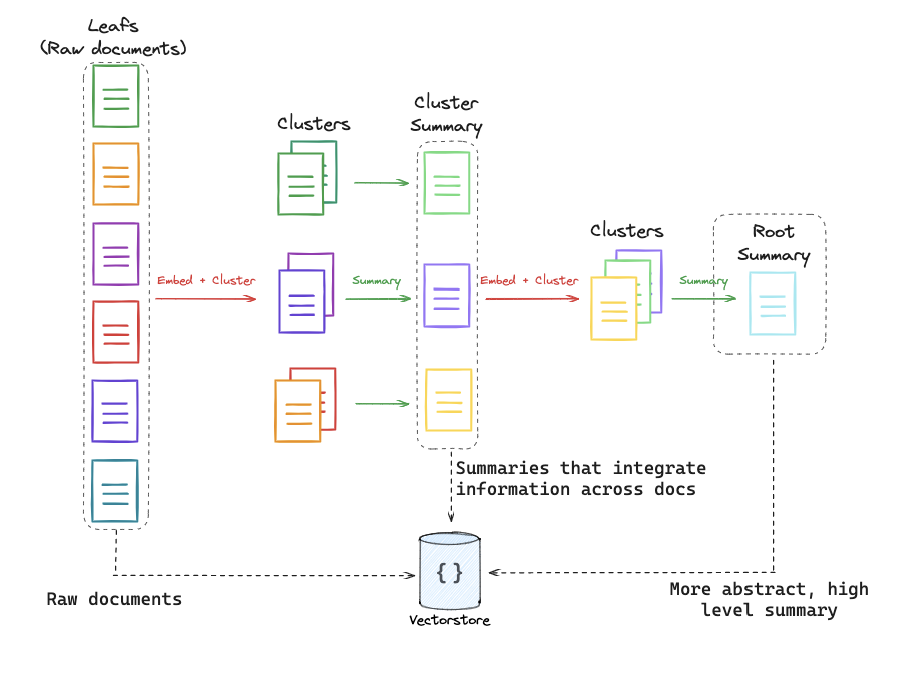

<function matplotlib.pyplot.show(close=None, block=None)>

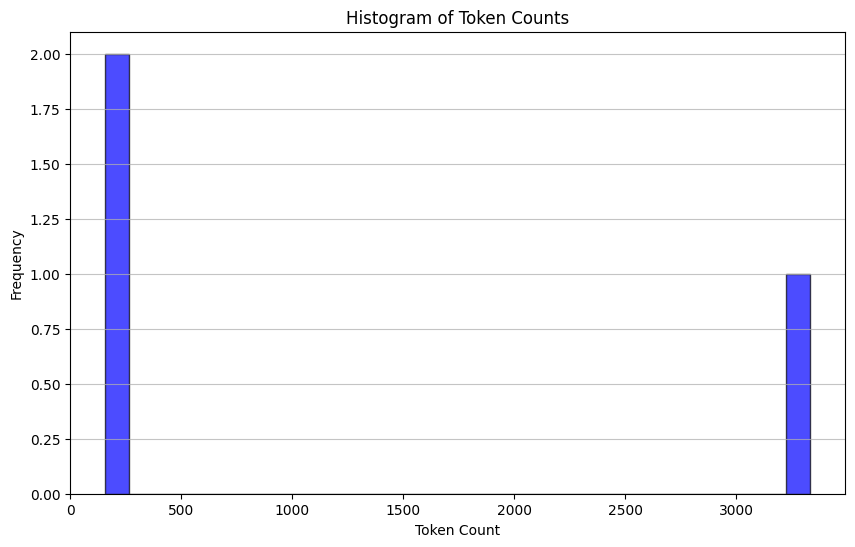

In [9]:
import matplotlib.pyplot as plt
import tiktoken
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader


def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


# LCEL docs
url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# LCEL w/ PydanticOutputParser (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/modules/model_io/output_parsers/quick_start"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_pydantic = loader.load()

# LCEL w/ Self Query (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/modules/data_connection/retrievers/self_query/"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_sq = loader.load()

# Doc texts
docs.extend([*docs_pydantic, *docs_sq])
docs_texts = [d.page_content for d in docs]

# Calculate the number of tokens for each document
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show

In [10]:
# Doc texts concat
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)


Num tokens in all context: 3650


In [11]:
# Doc texts split
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 2000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)
texts_split = text_splitter.split_text(concatenated_content)